In [28]:
import os
import cv2
import glob
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

## Dataset

In [29]:
# Step 1: 列出所有文件
rf_files = glob.glob('RF Station 1/RF1 csv/*_LF.csv')  # RF数据文件的路径和模式
label_dirs = glob.glob('Label_csv/')  # 标签数据文件夹的路径

print(rf_files)
print(label_dirs)
# Step 2: 解析文件名以提取时间，并创建一个映射关系
rf_times_files = {datetime.datetime.strptime(os.path.basename(f).split('_')[0], "%y%m%d%H%M%S"): f for f in rf_files}

label_files = []
for d in label_dirs:
    label_files.extend(glob.glob(f'{d}*.csv'))

label_times_files = {
    datetime.datetime.strptime(
        os.path.basename(f).split('_')[1].split('.')[0],  # 修正点在这里
        "%Y-%m-%d %H-%M-%S"
    ): f for f in label_files
}

# Step 3: 匹配RF数据和标签文件
matched_files = []
for rf_time, rf_file in rf_times_files.items():
    # 找到最接近rf_time的标签文件时间
    closest_label_time = min(label_times_files.keys(), key=lambda x: abs(x - rf_time))
    if abs(closest_label_time - rf_time) < datetime.timedelta(minutes=1):  # 假设时间差小于1分钟则视为匹配
        matched_files.append((rf_file, label_times_files[closest_label_time]))

['RF Station 1/RF1 csv\\240228160500_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\240228160700_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\240228160900_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\240228161100_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\240228161300_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\240228161500_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\240228161700_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\240228161900_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\240228163200_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\240228163400_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\240228163700_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\240228163900_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\240228164100_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\240228164400_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\240228164600_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\240229104700_30M__ch0Ref_Arr_LF.csv', 'RF Station 1/RF1 csv\\

## Checking the dataset

In [30]:
print(f"找到并匹配的文件对数量: {len(matched_files)}")

找到并匹配的文件对数量: 41


In [31]:
for i, (rf_file, label_file) in enumerate(matched_files[:5]):  # 打印前5对文件路径作为示例
    print(f"匹配对 {i+1}:")
    print(f"    RF数据文件: {rf_file}")
    print(f"    标签文件: {label_file}")
    print("-" * 60)

匹配对 1:
    RF数据文件: RF Station 1/RF1 csv\240228160500_30M__ch0Ref_Arr_LF.csv
    标签文件: Label_csv\demo_2024-02-28 16-05-00.csv
------------------------------------------------------------
匹配对 2:
    RF数据文件: RF Station 1/RF1 csv\240228160700_30M__ch0Ref_Arr_LF.csv
    标签文件: Label_csv\demo_2024-02-28 16-07-00.csv
------------------------------------------------------------
匹配对 3:
    RF数据文件: RF Station 1/RF1 csv\240228160900_30M__ch0Ref_Arr_LF.csv
    标签文件: Label_csv\demo_2024-02-28 16-09-00.csv
------------------------------------------------------------
匹配对 4:
    RF数据文件: RF Station 1/RF1 csv\240228161100_30M__ch0Ref_Arr_LF.csv
    标签文件: Label_csv\demo_2024-02-28 16-11-00.csv
------------------------------------------------------------
匹配对 5:
    RF数据文件: RF Station 1/RF1 csv\240228161300_30M__ch0Ref_Arr_LF.csv
    标签文件: Label_csv\demo_2024-02-28 16-13-00.csv
------------------------------------------------------------


## Preprocessing

In [32]:
# 自定义处理标签数据的函数
def get_majority_action(group):
    if group.isnull().all().all() or (group.drop('time', axis=1) <= 0.3).all().all():  # 检查组是否全部为 NaN 或 0，忽略时间列
        return "label empty"  # 如果是，返回一个特殊标记
    else:
        # 提取出现概率超过 0.3 的动作标签
        actions = group.drop('time', axis=1).columns[group.drop('time', axis=1).iloc[0] > 0.3].tolist()
        # 按照要求拼接成一个字符串
        action_str = ', '.join(actions)
        return action_str


# 初始化归一化器
scaler = MinMaxScaler()

# 用于存储处理后的RF数据和标签的列表
rf_data_processed = []
labels_processed = []

# 处理所有配对的文件
for rf_file, label_file in tqdm(matched_files):
    # 加载并预处理RF数据
    rf_data = pd.read_csv(rf_file, header=None, skiprows=849, nrows=301)
    rf_data_normalized = scaler.fit_transform(rf_data)
    rf_data_processed.append(rf_data_normalized)
    
    # 加载标签数据
    label_data = pd.read_csv(label_file)
    label_data['time'] = label_data['time'].apply(lambda x: int(x // 3))  # 重要：以xx行聚合
    
    # 对每个时间段应用自定义函数
    aggregated_records = []  # 初始化一个空列表来收集所有的记录
    for name, group in label_data.groupby('time'):
        action = get_majority_action(group)
        aggregated_records.append({'time': name, 'action': action})  # 将记录添加到列表
    
    aggregated_labels = pd.DataFrame(aggregated_records)  # 使用收集到的记录一次性创建DataFrame
    labels_processed.append(aggregated_labels)

# 此时，rf_data_processed 和 labels_processed 分别存储了所有RF数据和标签数据的处理结果


  0%|          | 0/41 [00:00<?, ?it/s]

100%|██████████| 41/41 [00:51<00:00,  1.26s/it]


In [33]:
# 提取每个标签数据的第二列（动作列）
labels_processed = [df.iloc[:, 1] for df in labels_processed]  # 假设动作是第二列

# 打印第一个处理后的动作数据的前几个元素查看
print("第一个处理后的动作数据（前5个）:")
print(labels_processed[0].head())


第一个处理后的动作数据（前5个）:
0    label empty
1    label empty
2    label empty
3    label empty
4    label empty
Name: action, dtype: object


In [34]:
# 检查第一个RF数据的维度
print("RF数据（处理后）的维度:")
print(np.array(rf_data_processed[0]).shape)

# 检查第一个标签数据的维度
print("\n标签数据（处理后）的维度:")
print(labels_processed[0].shape)



RF数据（处理后）的维度:
(301, 591)

标签数据（处理后）的维度:
(288,)


In [35]:
# 打印第一个处理后的RF数据的前几行
print("RF数据（处理后）的前几行:")
print(rf_data_processed[0][:5])
# 打印第一个处理后的标签数据
print("\n标签数据（处理后）的前几行:")
print(labels_processed[0].head(5))


RF数据（处理后）的前几行:
[[0.43616612 0.44722634 0.40252931 ... 0.37312871 0.33176852 0.3583344 ]
 [0.37576368 0.31956617 0.17861484 ... 0.34744476 0.18115654 0.27762621]
 [0.25311986 0.26774976 0.28305711 ... 0.3584563  0.30885131 0.34128384]
 [0.30350276 0.34541293 0.39742051 ... 0.34052037 0.33465957 0.36236031]
 [0.39744594 0.45295031 0.45261237 ... 0.18061134 0.24541466 0.36328373]]

标签数据（处理后）的前几行:
0    label empty
1    label empty
2    label empty
3    label empty
4    label empty
Name: action, dtype: object


In [36]:
# 验证RF数据类型
print("RF数据类型:")
print(type(rf_data_processed[0]))

# 验证标签数据类型
print("\n标签数据类型:")
print(labels_processed[0].dtypes)


RF数据类型:
<class 'numpy.ndarray'>

标签数据类型:
object


In [37]:
# 统计第一个标签数据中各动作标签的数量
print("\n标签分布情况:")
print(labels_processed[0].value_counts())



标签分布情况:
walk                         151
touch (an O), sit             47
label empty                   18
walk, talk                    16
sit                           10
stand                         10
walk, carry (an O)            10
get up                         8
touch (an O)                   5
walk, answer phone             2
walk, stand                    2
stand, touch (an O)            2
walk, stand, touch (an O)      2
sit, get up                    2
walk, touch (an O)             1
sit, answer phone              1
                               1
Name: action, dtype: int64


In [38]:
# 新建一个列表来保存平均后的数据
rf_data_averaged = []

for data in rf_data_processed:
    # 检查列数，确保是偶数列，如果是奇数列，去掉最后一列
    if data.shape[1] % 2 != 0:
        data = data[:, :-1]

    # 将数据重塑，使得每两列成为一组
    # data.shape[0] 是行数，data.shape[1]//2 是将列数减半
    reshaped_data = data.reshape(data.shape[0], -1, 2)
    
    # 计算每两列的平均值
    averaged_data = reshaped_data.mean(axis=2)
    
    # 将平均后的数据添加到新列表中
    rf_data_averaged.append(averaged_data)

# 现在 rf_data_averaged 包含所有处理后的RF数据集


In [39]:
# 确定所有RF数据和标签数据中最小的时间步
#min_length = 250
min_length = min(min(rf_data.shape[1] for rf_data in rf_data_averaged), min(len(label_data) for label_data in labels_processed))
# 裁剪所有RF数据和标签数据到这个最小时间步
rf_data_trimmed = [rf_data[:, :min_length] for rf_data in rf_data_averaged]  # 裁剪列
labels_trimmed = [label_data[:min_length] for label_data in labels_processed]  # 裁剪行


In [40]:
# 遍历处理后的数据对，并检查长度
for i, (rf_data, label_data) in enumerate(zip(rf_data_trimmed, labels_trimmed)):
    print(f"文件组 {i+1}:")
    print(f"  RF数据时间步数: {rf_data.shape[1]}")  # 列数代表时间步
    print(f"  标签时间步数: {len(label_data)}")

    # 检查长度是否匹配
    if rf_data.shape[1] == len(label_data):
        print("  数据长度匹配成功！")
    else:
        print("  数据长度不匹配。")


文件组 1:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 2:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 3:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 4:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 5:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 6:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 7:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 8:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 9:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 10:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 11:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 12:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 13:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 14:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 15:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 16:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 17:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 18:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 19:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 20:
  RF数据时间步数: 264
  标签时间步数: 264
  数据长度匹配成功！
文件组 21:
 

In [41]:
# 初始化 LabelEncoder
label_encoder = LabelEncoder()

# 因为labels_trimmed是一个列表的列表，我们需要先将它们扁平化，再进行编码
flat_labels = [label for sublist in labels_trimmed for label in sublist]

# 将分类标签转换为整数
integer_encoded = label_encoder.fit_transform(flat_labels)

# 如果需要后续查看或者转换回来，可以保存label_encoder
import pickle
pickle.dump(label_encoder, open("label_encoder.pkl", "wb"))

# 转换为独热编码
onehot_encoded = to_categorical(integer_encoded)

# 因为我们需要将独热编码的标签重新分配回对应的文件组，我们需要使用原来的结构信息
split_indices = [len(sublist) for sublist in labels_trimmed]
onehot_labels = np.split(onehot_encoded, np.cumsum(split_indices)[:-1])



In [42]:
# 打印出每个文件组的独热编码标签数据的前几行，以确保转换正确
for i, labels in enumerate(onehot_labels):
    print(f"文件组 {i+1} 的独热编码标签样本:")
    print(labels[:5])  # 打印每个文件组的前五个独热编码标签


文件组 1 的独热编码标签样本:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0

In [43]:
# 检查特征和标签数量是否匹配
print(f"特征样本数: {len(rf_data_trimmed)}, 标签样本数: {len(onehot_labels)}")

特征样本数: 41, 标签样本数: 41


## Trianing

In [44]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Bidirectional, Attention


In [45]:
'''
# 如果之前没有正确地堆叠为三维数组，可以使用以下代码
X = np.stack(rf_data_trimmed)
# 检查维度
print("堆叠后的RF数据维度:", X.shape)
# 我们需要将每个样本的最后两维转置，以便时间步在前，特征在后
X_transposed = np.transpose(X, (0, 2, 1))  # 0是样本维，2是原时间步维，1是原特征维
# 检查转置后的数据形状
print("转置后的数据维度:", X_transposed.shape)
# 假设onehot_labels是一个列表的列表，其中每个子列表都是一个样本的独热编码标签
y = np.stack(onehot_labels)  # 将标签数据堆叠成一个数组
# 检查标签数据的维度
print("堆叠后的标签数据维度:", y.shape)
'''

'\n# 如果之前没有正确地堆叠为三维数组，可以使用以下代码\nX = np.stack(rf_data_trimmed)\n# 检查维度\nprint("堆叠后的RF数据维度:", X.shape)\n# 我们需要将每个样本的最后两维转置，以便时间步在前，特征在后\nX_transposed = np.transpose(X, (0, 2, 1))  # 0是样本维，2是原时间步维，1是原特征维\n# 检查转置后的数据形状\nprint("转置后的数据维度:", X_transposed.shape)\n# 假设onehot_labels是一个列表的列表，其中每个子列表都是一个样本的独热编码标签\ny = np.stack(onehot_labels)  # 将标签数据堆叠成一个数组\n# 检查标签数据的维度\nprint("堆叠后的标签数据维度:", y.shape)\n'

In [46]:
# 将列表的列表转换为 NumPy 数组
X = np.stack(rf_data_trimmed)  # 假设 rf_data_trimmed 是列表的列表
y = np.stack(onehot_labels)  # 假设 onehot_labels 是列表的列表
X_transposed = np.transpose(X, (0, 2, 1))  # 调整原始数据维度以适应 (样本数, 时间步, 特征数)

print("原始数据维度:", X.shape)
print("原始标签维度:", y.shape)
print("旋转标签维度:", X_transposed.shape)

def sliding_window(features, labels, window_size, step_size):
    segment_features = []
    segment_labels = []
    # 对每一个样本应用滑动窗口
    for sample_features, sample_labels in zip(features, labels):
        for start_pos in range(0, sample_features.shape[0] - window_size + 1, step_size):
            end_pos = start_pos + window_size
            segment_feat = sample_features[start_pos:end_pos, :]
            segment_label = sample_labels[start_pos:end_pos, :]
            segment_features.append(segment_feat)
            segment_labels.append(segment_label)
    return np.array(segment_features), np.array(segment_labels)

# 假设 X_transposed 和 y 已经是您处理后，时间步在第一维的数据
window_size = 100  # 定义窗口大小
step_size = 10    # 定义步长

X_windows, y_windows = sliding_window(X_transposed, y, window_size, step_size)

# 打印新的数据维度来确认变化
print("滑动窗口处理后的特征维度:", X_windows.shape)
print("滑动窗口处理后的标签维度:", y_windows.shape)



原始数据维度: (41, 301, 264)
原始标签维度: (41, 264, 195)
旋转标签维度: (41, 264, 301)
滑动窗口处理后的特征维度: (697, 100, 301)
滑动窗口处理后的标签维度: (697, 100, 195)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_windows, y_windows, test_size=0.05, random_state=42)

In [48]:
# 重新构建模型
model = Sequential([
    Bidirectional(LSTM(50, input_shape=(100, 301), return_sequences=True)),  # 输入形状：时间步长为264，每步有301个特征
    Dropout(0.2),
    Bidirectional(LSTM(50, return_sequences=True)),  # 第二层LSTM，返回序列以供下一层处理
    Dropout(0.2),
    TimeDistributed(Dense(y_windows.shape[-1], activation='softmax'))  # 在每个时间步输出19个类别的概率
])

# 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 构建模型
model.build((None, 100, 301))  # 传入一个样本的形状来构建模型

# 显示模型结构
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 100, 100)          140800    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 100, 100)          60400     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 100, 100)          0         
                                                                 
 time_distributed_1 (TimeDi  (None, 100, 195)          19695     
 stributed)                                                      
                                                      

In [49]:
# 训练模型，这里假设 X_train, y_train, X_test, y_test 已经正确准备和维度匹配
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    validation_data=(X_test, y_test)
)


Epoch 1/300
11/11 [==============================] - 22s 608ms/step - loss: 4.5097 - accuracy: 0.2837 - val_loss: 3.8832 - val_accuracy: 0.3000
Epoch 2/300
11/11 [==============================] - 3s 295ms/step - loss: 3.6997 - accuracy: 0.3137 - val_loss: 3.4834 - val_accuracy: 0.3000
Epoch 3/300
11/11 [==============================] - 3s 291ms/step - loss: 3.4274 - accuracy: 0.3127 - val_loss: 3.3972 - val_accuracy: 0.3000
Epoch 4/300
11/11 [==============================] - 3s 261ms/step - loss: 3.3629 - accuracy: 0.3119 - val_loss: 3.3971 - val_accuracy: 0.3000
Epoch 5/300
11/11 [==============================] - 3s 292ms/step - loss: 3.3388 - accuracy: 0.3135 - val_loss: 3.3873 - val_accuracy: 0.3000
Epoch 6/300
11/11 [==============================] - 3s 268ms/step - loss: 3.3254 - accuracy: 0.3136 - val_loss: 3.3759 - val_accuracy: 0.3000
Epoch 7/300
11/11 [==============================] - 3s 269ms/step - loss: 3.3076 - accuracy: 0.3137 - val_loss: 3.3543 - val_accuracy: 0.300

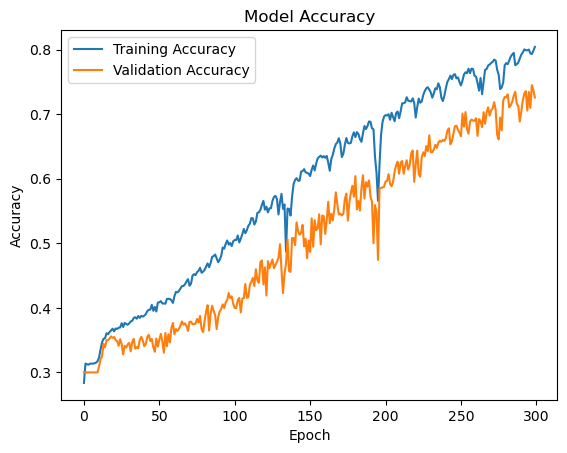

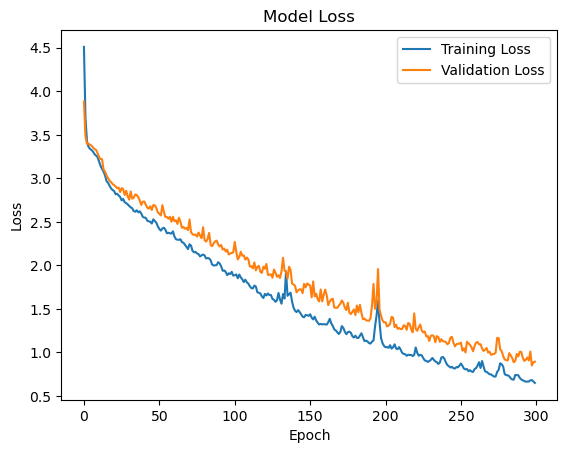

In [50]:
import matplotlib.pyplot as plt

# 绘制训练和验证的准确率
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# 绘制训练和验证的损失
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [55]:
# 读取CSV文件
new_data = pd.read_csv('Model_Test_Data/240228163000_30M__ch0Ref_Arr_LF.csv', header=None, skiprows=849, nrows=301)
new_data_normalized = scaler.fit_transform(new_data)
new_data_processed = []
new_data_processed.append(new_data_normalized)
print(np.array(new_data_processed[0]).shape)
print("RF数据（处理后）的前几行:")
print(new_data_processed[0][:5])
print("RF数据类型:")
print(type(new_data_processed[0]))

# 新建一个列表来保存平均后的数据
new_data_averaged = []

for data in new_data_processed:
    # 检查列数，确保是偶数列，如果是奇数列，去掉最后一列
    if data.shape[1] % 2 != 0:
        data = data[:, :-1]

    # 将数据重塑，使得每两列成为一组
    # data.shape[0] 是行数，data.shape[1]//2 是将列数减半
    reshaped_data = data.reshape(data.shape[0], -1, 2)
    
    # 计算每两列的平均值
    averaged_data = reshaped_data.mean(axis=2)
    
    # 将平均后的数据添加到新列表中
    new_data_averaged.append(averaged_data)
# 现在 rf_data_averaged 包含所有处理后的RF数据集

Validation = np.stack(new_data_averaged)
Validation_transposed = np.transpose(Validation, (0, 2, 1)) 
print("原始数据维度:", Validation.shape)
print("旋转标签维度:", Validation_transposed.shape)

# 使用模型进行预测
predictions = model.predict(Validation_transposed)

# 处理预测结果
predicted_class = np.argmax(predictions, axis=-1)
print("Predicted class:", predicted_class)

original_labels = label_encoder.inverse_transform(predicted_class.flatten())
print("Original labels:", original_labels)

(301, 591)
RF数据（处理后）的前几行:
[[0.44935474 0.5087403  0.45117192 ... 0.224469   0.15639984 0.27191976]
 [0.41905812 0.48810298 0.46681824 ... 0.27135987 0.         0.24700113]
 [0.29241596 0.37155692 0.37895512 ... 0.38720866 0.37887553 0.3725359 ]
 [0.24893598 0.33925878 0.37509539 ... 0.46675479 0.46463016 0.35993349]
 [0.36483236 0.47145822 0.49200006 ... 0.44198222 0.41144706 0.37333448]]
RF数据类型:
<class 'numpy.ndarray'>
原始数据维度: (1, 301, 295)
旋转标签维度: (1, 295, 301)
1/1 [==============================] - 0s 82ms/step
Predicted class: [[ 59  59  59  59  59  59  59  59  59  59  59  59  59  59  59  59  59  59
   59  59  59  59  59  59  59  59  59  59  59  59  59  59  59  59  59  59
   59  59  59  59  59  59  59  59  59  59  59  59  59  59  59  59  59  59
   59  59  59  59  59  59  59  59 147 147 147 147 147 147 147 147 147 147
  147 147 147 147 147 147 147 147 147 147 147 147 147 147 147 147 147 147
  147 147 147 147 147 147 147 147 147 147 147 147 147 147 147 147 147 147
  147 147 147 147 1

In [57]:
# Define video file path
video_path = 'Model_Test_Data/demo_2024-02-28 16-30-00_.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video file is opened successfully
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

# Define output video file path
output_video_path = 'Model_Test_Output/02281630_LF_ML3.mp4'

# Define font and text color
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 2
font_color = (0, 0, 255)  # red color   

# Define box parameters
box_position = (1615, 0)  # top-left corner coordinates of the box
box_width = 1078
box_height = 100
box_color = (0, 0, 255)  # red color
box_thickness = 2

# Define frame rate (fps) of output video
fps = cap.get(cv2.CAP_PROP_FPS)

# Define VideoWriter object to write the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # codec
out = cv2.VideoWriter(output_video_path, fourcc, fps, (int(cap.get(3)), int(cap.get(4))))

# Multiply each label by 3 in sequence
tripled_labels = []
for label in original_labels:
    tripled_labels.extend([label] * 3)



# Iterate through each frame of the video
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Add box to the frame
    cv2.rectangle(frame, box_position, (box_position[0] + box_width, box_position[1] + box_height), box_color, box_thickness)

    # Add label to the box for the current frame
    if frame_count < len(tripled_labels):
        label = tripled_labels[frame_count]
        label_size = cv2.getTextSize(label, font, font_scale, 2)[0]  # Get size of the label text
        label_position = (box_position[0] + 10, box_position[1] + label_size[1] + 5)  # Position of the label text
        cv2.putText(frame, label, label_position, font, font_scale, font_color, 2)

    # Write the frame to the output video file
    out.write(frame)
    
    frame_count += 1

# Release video capture and writer objects
cap.release()
out.release()

print(f"Output video saved to {output_video_path}.")

Output video saved to Model_Test_Output/02281630_LF_ML3.mp4.


#Independent Cell to Check the Size of the Box

In [53]:

import cv2

# Load the video
cap = cv2.VideoCapture('Model_Test_Data/demo_2024-02-29 11-24-00_.mp4')

# Read one frame
ret, frame = cap.read()

# Define the relative position of the box (e.g., top-left corner)
relative_x = 1615  # distance from the left edge
relative_y = 0  # distance from the top edge

# Define the size of the box (e.g., width and height)
box_width = 1078
box_height = 100

# Determine the coordinates of the box
box_x1 = relative_x
box_y1 = relative_y
box_x2 = relative_x + box_width
box_y2 = relative_y + box_height

# Draw the box on the frame
cv2.rectangle(frame, (box_x1, box_y1), (box_x2, box_y2), (0, 0, 255), 2)

# Resize the frame to fit the screen
scale_percent = 40  # percent of original size
width = int(frame.shape[1] * scale_percent / 100)
height = int(frame.shape[0] * scale_percent / 100)
dim = (width, height)
resized_frame = cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

# Display the resized frame with the box
cv2.imshow('Frame with Box', resized_frame)
cv2.waitKey(0)  # Wait for any key to be pressed
cv2.destroyAllWindows()

# Release the video capture object
cap.release()
